# 1- [50 pt] Part a)

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

pd.options.mode.chained_assignment = None 

df = pd.read_csv('../datasets/churn.txt')

# DROP specified columns
df = df.drop(df.columns[[0, 2, 3, 5, 9, 11, 12, 14, 15, 18]], axis=1)

# ENCODE categorical features (Int'l Plan, Churn?) using Label Encoding (essentially One Hot Encoding)
labelencoder = LabelEncoder()
df['Int\'l Plan'] = labelencoder.fit_transform(df['Int\'l Plan'])
df['Churn?'] = labelencoder.fit_transform(df['Churn?'])

# NORMALIZE the numerical variables 
scaler = MinMaxScaler(feature_range=(-1,1)) 
df[["Account Length", "VMail Message", "Day Mins", "Day Calls", "Eve Mins",  "Night Mins", "Intl Mins", "Intl Calls", "CustServ Calls"]] = scaler.fit_transform(df[["Account Length", "VMail Message", "Day Mins", "Day Calls", "Eve Mins",  "Night Mins", "Intl Mins", "Intl Calls", "CustServ Calls"]])

# SPLIT the data (70:30)
train_x, test_x, train_y, test_y = train_test_split(df.drop('Churn?', axis=1), df['Churn?'], test_size = 0.3, random_state=0)

train_x.head()


,Account Length,Int'l Plan,VMail Message,Day Mins,Day Calls,Eve Mins,Night Mins,Intl Mins,Intl Calls,CustServ Calls
2918,-0.528926,0,-1.000000,-0.005701,0.357576,0.461644,-0.143626,-1.00,-1.0,-0.111111
1884,-0.586777,1,-0.529412,-0.225770,-0.272727,0.103107,-0.089833,0.23,-0.3,-0.555556
2823,-0.289256,0,-1.000000,0.130559,-0.030303,0.028320,-0.406670,0.66,-0.6,-0.555556
2319,-0.322314,0,0.176471,0.553592,0.272727,0.391257,-0.152232,-0.13,-0.4,-0.333333
2980,-0.314050,0,-1.000000,0.287913,0.042424,0.515535,-0.041420,0.43,-0.7,-0.333333


In [149]:
# create a func for a generalized creation of ANN model
def create_model(neurons):
    model = keras.Sequential()
    for i, nodes in enumerate(neurons):
        if i==0:
            model.add(layers.Dense(nodes, input_dim=df.drop('Churn?', axis=1).shape[1],  activation='sigmoid'))
        else:
            model.add(layers.Dense(nodes, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid')) # last output layero
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy',    
                    keras.metrics.Precision(name="precision" , thresholds=0.5),
                    keras.metrics.Recall(name="recall",thresholds=0.5)])
    return model

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose = 0)

# TUNE parameters (neurons)
# define the grid search parameters 
neurons = [[3,5],[7,9],[10,4],[10,15],[12,17],[17,12],[15,15],[17,15],[15,17],[17,17],[17,20],[20,15],[20,16],[20,17],[20,18],[20,19],[15,20],[17,20],[20,20],[25,30],[30,25],[30,40],[40,30]]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train_x, train_y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.904408 using {'neurons': [40, 30]}
0.868405 (0.007463) with: {'neurons': [3, 5]}
0.882550 (0.011344) with: {'neurons': [7, 9]}
0.880415 (0.014481) with: {'neurons': [10, 4]}
0.882126 (0.016324) with: {'neurons': [10, 15]}
0.889837 (0.014684) with: {'neurons': [12, 17]}
0.895404 (0.015907) with: {'neurons': [17, 12]}
0.891121 (0.014487) with: {'neurons': [15, 15]}
0.895400 (0.015099) with: {'neurons': [17, 15]}
0.891974 (0.015034) with: {'neurons': [15, 17]}
0.895834 (0.015017) with: {'neurons': [17, 17]}
0.896690 (0.015138) with: {'neurons': [17, 20]}
0.896689 (0.016087) with: {'neurons': [20, 15]}
0.893690 (0.014074) with: {'neurons': [20, 16]}
0.894550 (0.014992) with: {'neurons': [20, 17]}
0.898404 (0.014145) with: {'neurons': [20, 18]}
0.897973 (0.017159) with: {'neurons': [20, 19]}
0.894546 (0.016315) with: {'neurons': [15, 20]}
0.894116 (0.014854) with: {'neurons': [17, 20]}
0.896262 (0.012695) with: {'neurons': [20, 20]}
0.899692 (0.013651) with: {'neurons': [25, 30]}
0.

When trained the model with the mean of normalized data at 0 then I got the same mean(0.852122) and stdev for each trial of number of neurons. I went back to the standart MinMax Scaler. 

The MSE between all the trials is not very different, but the best result is: 40 neurons for the 1st hidden layer and 30 neurons for the 2nd hidden layer. This is a lot neurons to make calculations for. In addition, I found out that if I specify more than 14 neurons in the second hidden layer, then the weights wouldn't update. I will choose \[5,5\] neurons amount for simplicity to show my calculations for the next part.  

# Part b) 
For the ANN in part a), calculate the first round of weight updates with back-propagation with paper and pencil for the two final layers (output to 2nd hidden layer; 2nd hidden layer to 1st hidden layer) for only the first sample.

Confirm that the numbers you calculated are the same as those produced by the code and provide both your calculations and the code output. Make sure that the loss function used in your hand calculation is the same as the one used in Keras.



In [150]:
# INITIALIZE the weights and biases for Hidden Layer 1 to 0
# INITIALIZE the weights and biases for Hidden Layer 2 and the Output Layer to 1.

def create_model_2(neurons):
    model = keras.Sequential()
    for i, nodes in enumerate(neurons):
        if i==0:
            model.add(layers.Dense(nodes, input_dim=df.drop('Churn?', axis=1).shape[1],  
                      kernel_initializer='zeros',  # Layer 2 - Init: 0
                      bias_initializer='zeros',    # Layer 2 - Init: 0 
                      activation='sigmoid'))
        else:
            model.add(layers.Dense(nodes, 
                      kernel_initializer='ones',  # Layer 3 - Init: 1
                      bias_initializer='ones',    # Layer 3 - Init: 1
                      activation='sigmoid'))
    model.add(layers.Dense(1, 
                      kernel_initializer='ones',  # Layer 4 - Init: 1
                      bias_initializer='ones',    # Layer 4 - Init: 1 
                      activation='sigmoid'))      # last output layer
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")                                       # momentum
    model.compile(loss='mse', optimizer=sgd, metrics=['accuracy',               
                    keras.metrics.Precision(name="precision" , thresholds=0.5),
                    keras.metrics.Recall(name="recall",thresholds=0.5)])
    return model

weights = []

model2 = create_model_2([5,5])
print("X: ", train_x.head(1))
print("Y: ", train_y.head(1))
result = model2.train_on_batch(train_x.head(1), train_y.head(1))



X:        Account Length  Int'l Plan  VMail Message  Day Mins  Day Calls  \
2918       -0.528926           0           -1.0 -0.005701   0.357576   

      Eve Mins  Night Mins  Intl Mins  Intl Calls  CustServ Calls  
2918  0.461644   -0.143626       -1.0        -1.0       -0.111111  
Y:  2918    0
Name: Churn?, dtype: int64


In [151]:
# Weights and bias weight layer 2 -> 3
model2.layers[1].get_weights()

[array([[0.99999917, 0.99999917, 0.99999917, 0.99999917, 0.99999917],
        [0.99999917, 0.99999917, 0.99999917, 0.99999917, 0.99999917],
        [0.99999917, 0.99999917, 0.99999917, 0.99999917, 0.99999917],
        [0.99999917, 0.99999917, 0.99999917, 0.99999917, 0.99999917],
        [0.99999917, 0.99999917, 0.99999917, 0.99999917, 0.99999917]],
       dtype=float32),
 array([0.9999984, 0.9999984, 0.9999984, 0.9999984, 0.9999984],
       dtype=float32)]

In [152]:
# Weights and bias layer 3 -> output neuron
model2.layers[2].get_weights()

[array([[0.99994475],
        [0.99994475],
        [0.99994475],
        [0.99994475],
        [0.99994475]], dtype=float32),
 array([0.9999431], dtype=float32)]

In [153]:
# Loss
print("Loss(MSE): ", result[0])

Loss(MSE):  0.9942845702171326


There is a small difference in the calculated by hand values. But on the other hand they are consistent. Run the code bellow to open the images in this file. Make sure the images are located in the same directory as this ipynb file...

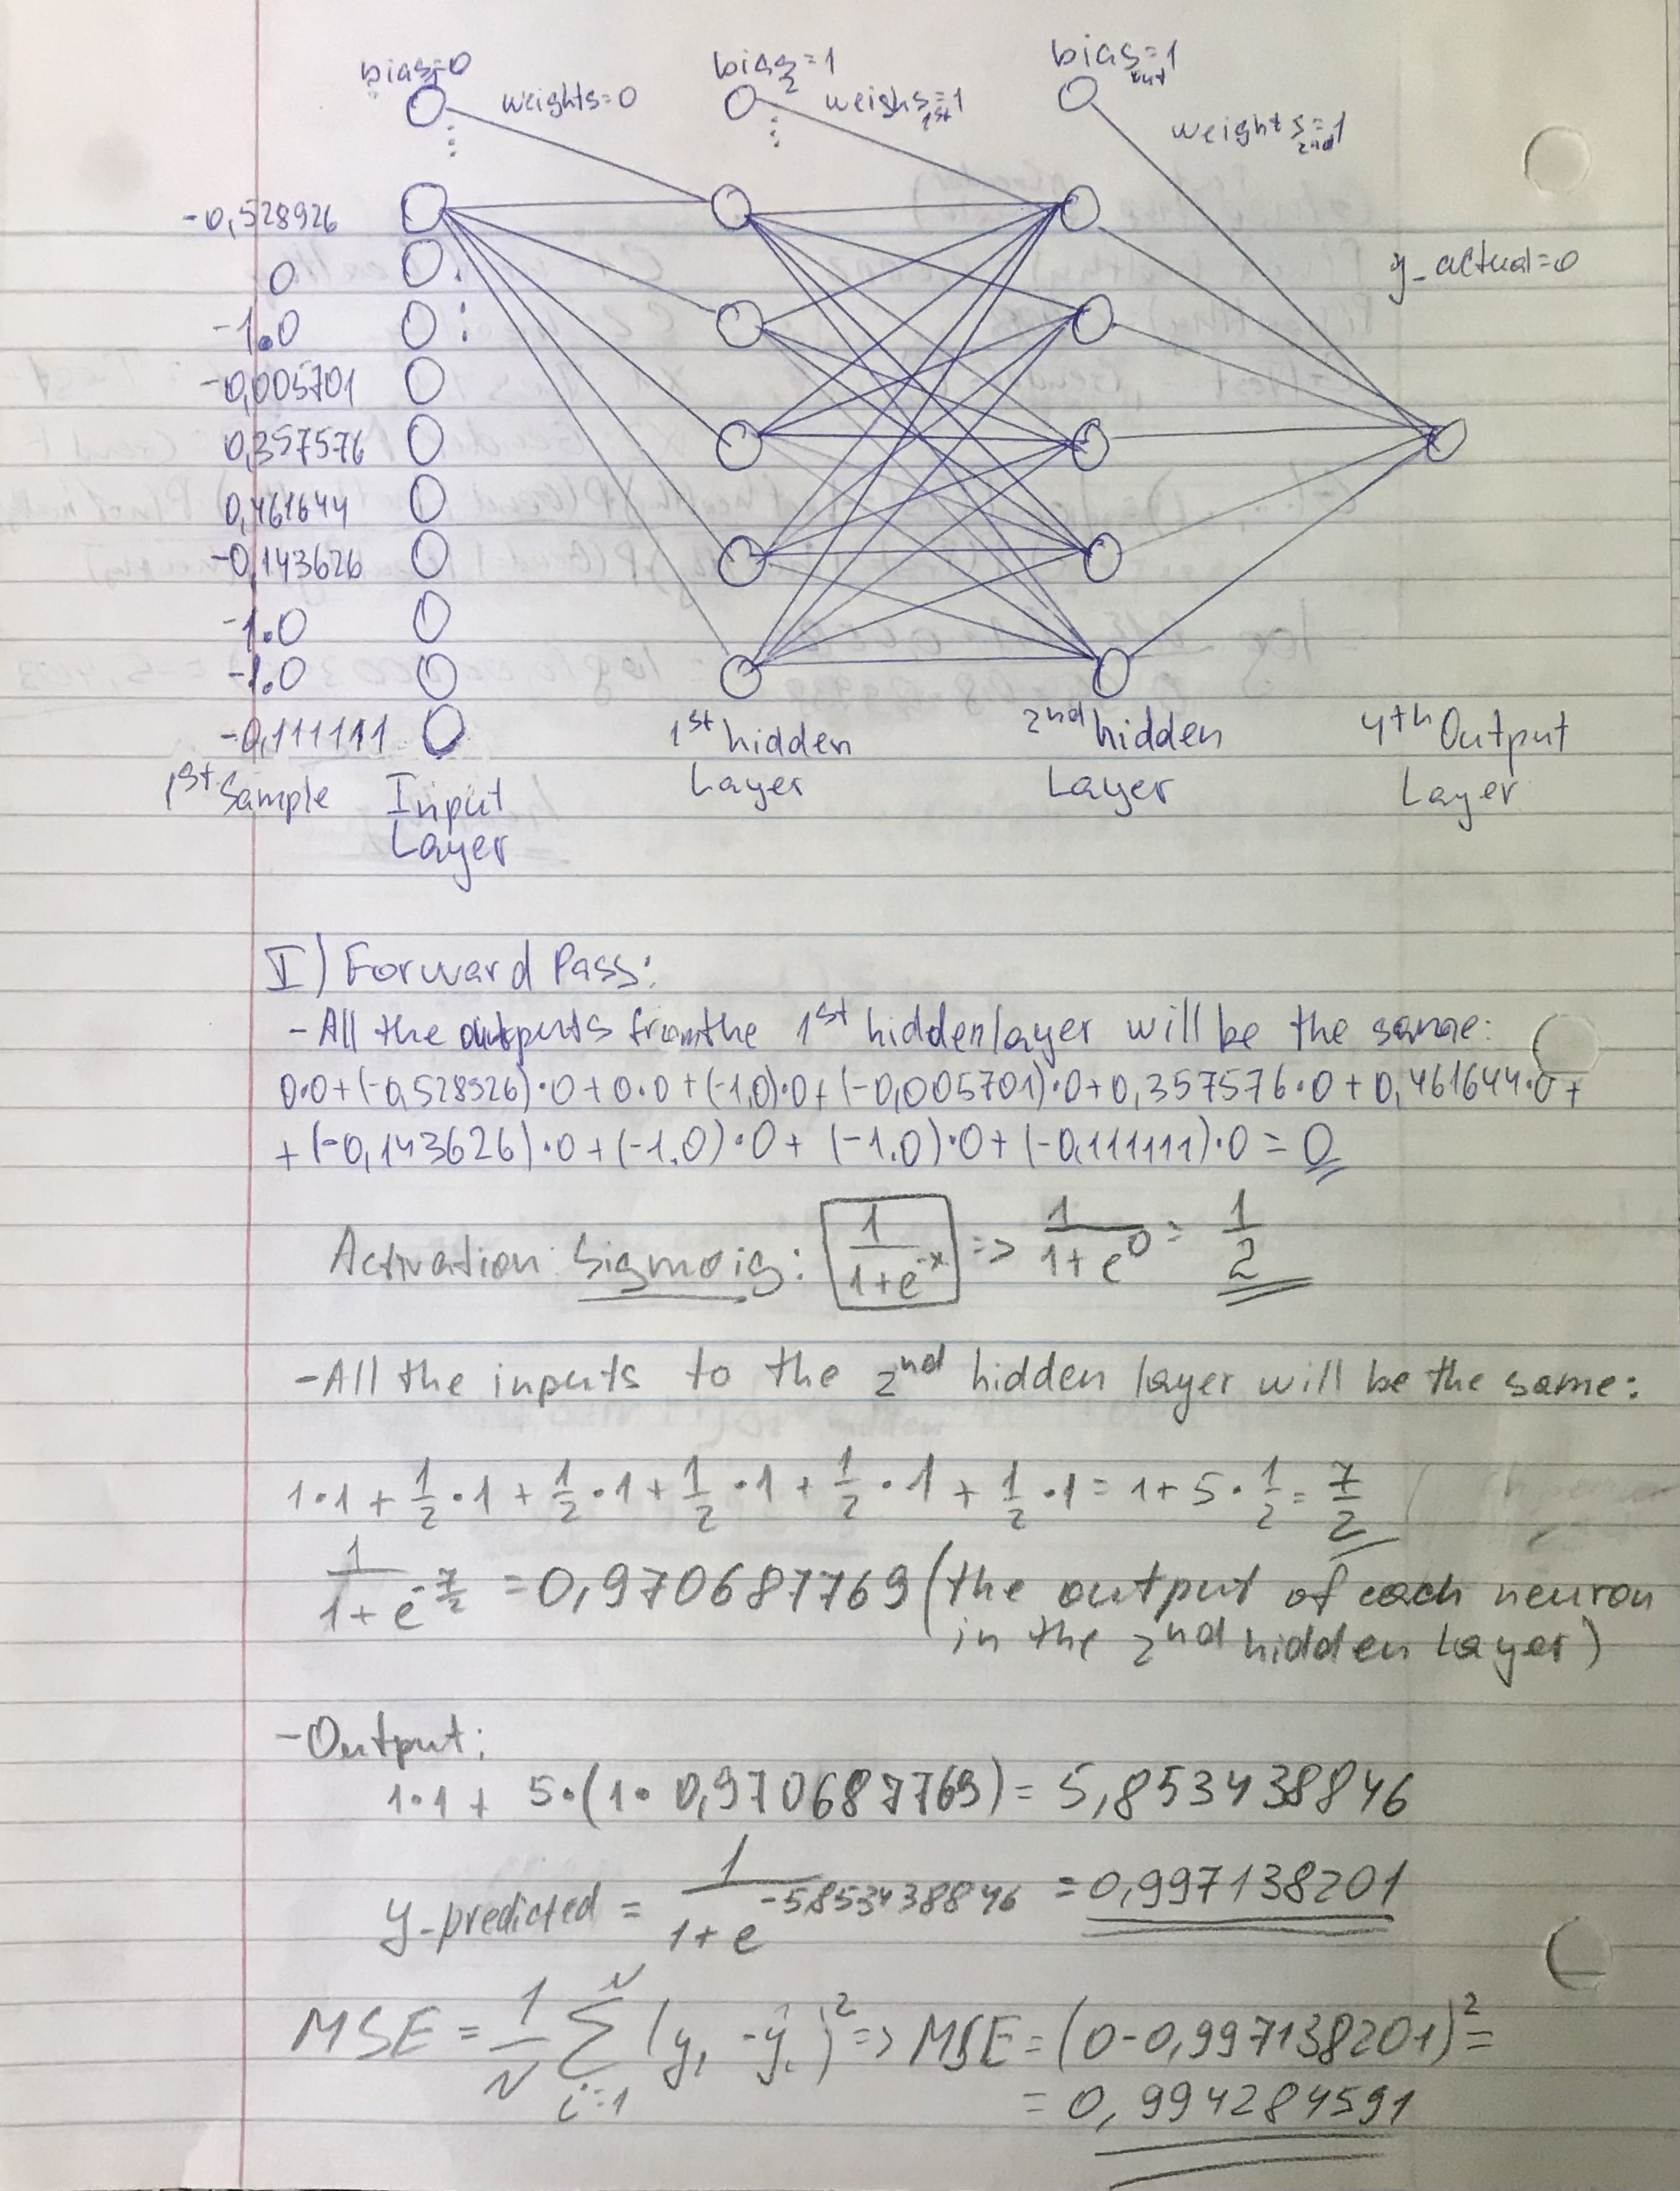

In [96]:
from IPython import display
display.Image("./1.jpg")


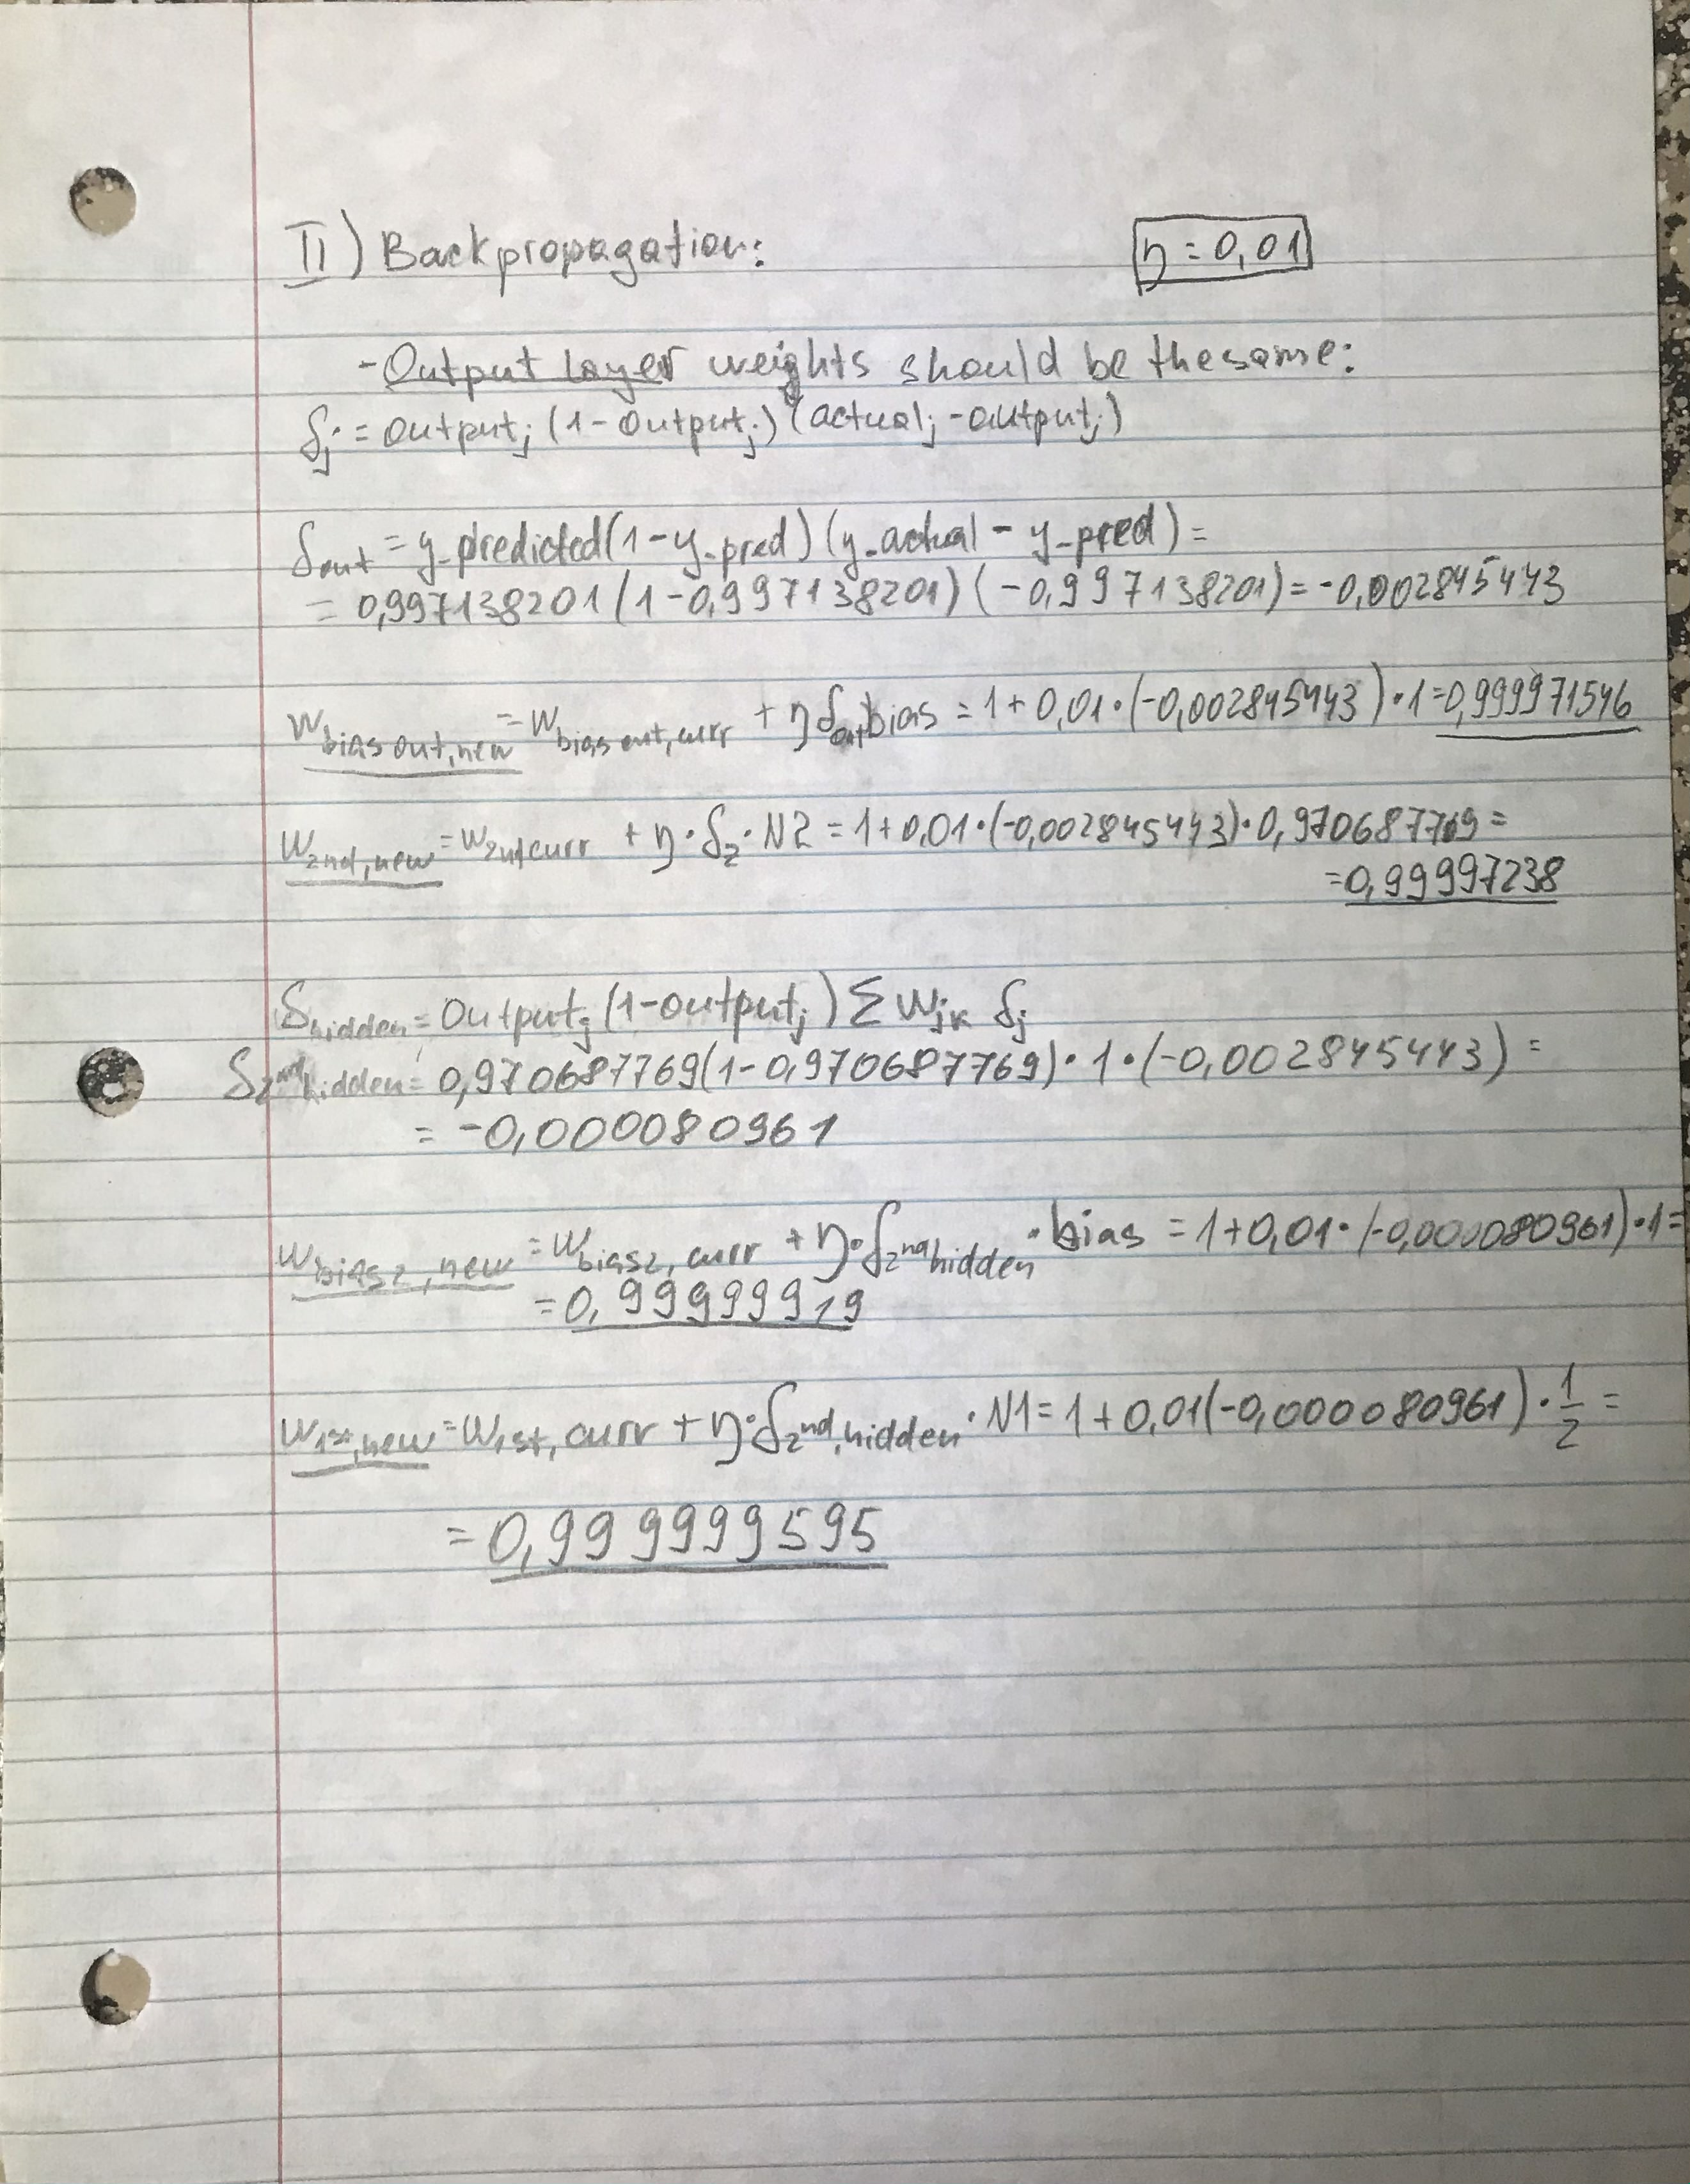

In [97]:
display.Image("./2.jpg")

# 2- [20 pt]
Create 2 dummy input samples and use the ANN model which you trained in Q1a to classify the output. Include your code and the classified output.

In [158]:
# create the model and train it
model3 = create_model([40,30])
result = model3.fit(train_x, train_y, epochs=500, batch_size=16, verbose=1)

# generate two samples
# ['Account Length', 'Int'l Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins', 'Night Mins', 'Intl Mins', 'Intl Calls', 'CustServ Calls', 'Churn?']

# 1st sample - within the range of observed features; 2nd - outside the range of observed features
samples_data = [[63, 0, 15, 202.400, 47, 249.500, 53.200, 5.000, 2, 5, 1], [260, 1, 80, 357.100, 161, 401.200, 12.900, 48.00, 21, 19, 0]]

# Create the pandas DataFrame
dummy = pd.DataFrame(samples_data, columns = ['Account Length', 'Int\'l Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins', 'Night Mins', 'Intl Mins', 'Intl Calls', 'CustServ Calls', 'Churn?'])


6 [==============================] - 0s 782us/step - loss: 0.0411 - accuracy: 0.9546 - precision: 0.9107 - recall: 0.7681
Epoch 361/500
146/146 [==============================] - 0s 792us/step - loss: 0.0411 - accuracy: 0.9537 - precision: 0.9129 - recall: 0.7594
Epoch 362/500
146/146 [==============================] - 0s 791us/step - loss: 0.0409 - accuracy: 0.9559 - precision: 0.9172 - recall: 0.7710
Epoch 363/500
146/146 [==============================] - 0s 803us/step - loss: 0.0408 - accuracy: 0.9541 - precision: 0.9075 - recall: 0.7681
Epoch 364/500
146/146 [==============================] - 0s 953us/step - loss: 0.0408 - accuracy: 0.9550 - precision: 0.9167 - recall: 0.7652
Epoch 365/500
146/146 [==============================] - 0s 797us/step - loss: 0.0406 - accuracy: 0.9563 - precision: 0.9147 - recall: 0.7768
Epoch 366/500
146/146 [==============================] - 0s 812us/step - loss: 0.0406 - accuracy: 0.9563 - precision: 0.9091 - recall: 0.7826
Epoch 367/500
146/146 [===

In [159]:
model3.predict(dummy.drop('Churn?', axis=1))

array([[1.],
       [1.]], dtype=float32)

In [160]:
# training
model3.evaluate(train_x, train_y)

73/73 [==============================] - 0s 615us/step - loss: 0.0340 - accuracy: 0.9657 - precision: 0.9553 - recall: 0.8058


[0.03398210555315018,
 0.965709388256073,
 0.9553264379501343,
 0.8057971000671387]

In [161]:
# test
model3.evaluate(test_x, test_y)

32/32 [==============================] - 0s 837us/step - loss: 0.0474 - accuracy: 0.9400 - precision: 0.8145 - recall: 0.7319


[0.047394879162311554,
 0.9399999976158142,
 0.8145161271095276,
 0.7318840622901917]

# 3- [20 pt]
Change the hidden layer activation functions to ReLU, the output layer activation to softmax, and the loss function to cross-entropy. Is this a better choice?


In [163]:
def create_model_4(neurons):
    model = keras.Sequential()
    for i, nodes in enumerate(neurons):
        if i==0:
            model.add(layers.Dense(nodes, input_dim=df.drop('Churn?', axis=1).shape[1],  activation='relu'))
        else:
            model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dense(1, activation='softmax')) # last output layer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',                       keras.metrics.Precision(name="precision" , thresholds=0.5),
                   keras.metrics.Recall(name="recall",thresholds=0.5)])
    return model

model4 = create_model_4([40,30])
result = model4.fit(train_x, train_y , epochs=500, batch_size=16, verbose=0)

{x:result.history[x][-1] for x in result.history.keys() if x in ['precision', 'recall', 'val_precision', 'val_recall']}

{'precision': 0.1478782743215561, 'recall': 1.0}

In [172]:
# training
model4.evaluate(train_x, train_y)

73/73 [==============================] - 0s 628us/step - loss: 0.0113 - accuracy: 0.1479 - precision: 0.1479 - recall: 1.0000


[0.011295074597001076, 0.1478782743215561, 0.1478782743215561, 1.0]

In [173]:
# test
model4.evaluate(test_x, test_y)

32/32 [==============================] - 0s 839us/step - loss: 0.5275 - accuracy: 0.1380 - precision: 0.1380 - recall: 1.0000


[0.5274978876113892, 0.1379999965429306, 0.1379999965429306, 1.0]

Based on the accuracy and precision previous model performs much better. In addition it has smaller loss, which again makes it a better model.

# 4- [10 pt]
### Describe the trade-off between a large hidden layer and a small one. What are the benefits, what are the drawbacks? 

A large hidden layer takes longer to learn, but it is more accurate; however, if the number of neurons is really large then this can produce overfitting. On the other hand, a small hidden layer takes much less to learn, but it does not make the model to be more generalized because of the possible underfitting.

### Also, describe the benefits and drawbacks of using a large or small values for learning rate in a NN.

Learning rate is all about the how fast the model will learn. Larger rate will help the model to learn faster, but the problem is that the model can get stuck in the local minimum, but we want to find the global one. A small learning rate will definitely find more optimal minimum or even the global one; however, it will take so much time to train the model. 


